SETUP & DATA LOADING

In [2]:
import numpy as np
import pandas as pd
import os 
from pathlib import Path

# root folder
PROJECT_ROOT = Path("ETHUSDT_Strategy.jpynb").resolve().parent.parent
print(PROJECT_ROOT) 
DATA_DIR = os.path.join(PROJECT_ROOT, "data/ETHUSDT.csv")
print(DATA_DIR)

/home/jovyan/quant
/home/jovyan/quant/data/ETHUSDT.csv


In [3]:
df_raw = pd.read_csv(DATA_DIR, parse_dates=['timestamp'], index_col='timestamp')

In [4]:
df_raw.head()

open    high     low   close  volume
timestamp                                                  
2019-11-27 07:30:00  146.00  146.00  146.00  146.00    0.01
2019-11-27 08:00:00  125.03  125.03  125.03  125.03    0.01
2019-11-27 08:30:00  145.00  145.01  133.00  133.00    0.07
2019-11-27 09:00:00  133.00  133.00  133.00  133.00    0.00
2019-11-27 09:30:00  133.00  133.00  133.00  133.00    0.00

In [5]:
print(df_raw.columns)

Index(['open', 'high', 'low', 'close', 'volume'], dtype='object')


DATA EXPLORATION 

In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100222 entries, 2019-11-27 07:30:00 to 2025-08-15 06:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    100222 non-null  float64
 1   high    100222 non-null  float64
 2   low     100222 non-null  float64
 3   close   100222 non-null  float64
 4   volume  100222 non-null  float64
dtypes: float64(5)
memory usage: 4.6 MB


In [7]:
df_raw.describe()

open           high            low          close  \
count  100222.000000  100222.000000  100222.000000  100222.000000   
mean     2020.850894    2028.743724    2012.538468    2020.895240   
std      1142.978576    1147.338935    1138.329111    1142.993254   
min        95.730000      98.440000      84.230000      95.730000   
25%      1293.550000    1298.292500    1288.550000    1293.560000   
50%      1909.370000    1915.320000    1902.850000    1909.395000   
75%      2905.067500    2916.990000    2890.315000    2905.132500   
max      4852.000000    4877.540000    4843.580000    4852.080000   

             volume  
count  1.002220e+05  
mean   6.953105e+04  
std    8.654758e+04  
min    0.000000e+00  
25%    2.393219e+04  
50%    4.340188e+04  
75%    8.126771e+04  
max    1.915609e+06

In [8]:
print(df_raw.isnull().sum())

open      0
high      0
low       0
close     0
volume    0
dtype: int64


In [9]:
print(f"From: {df_raw.index.min()}")
print(f"To: {df_raw.index.max()}")

From: 2019-11-27 07:30:00
To: 2025-08-15 06:00:00


FEATURE ENGINEERING

In [10]:
def generate_features(df_features):
    # copy
    df_features = df_raw.copy()
    
    # RETURN
    df_features['return_1'] = df_features['close'].pct_change()       # 30 minute return  
    df_features['return_4'] = df_features['close'].pct_change(4)      # 2 hours return 
    df_features['return_48'] = df_features['close'].pct_change(48)    # 24 hours return
    df_features['return_96'] = df_features['close'].pct_change(96)    # 2 days return 

    # VOLATILITY
    df_features['volatility_24'] = df_features['return_1'].rolling(48).std()       # 24 hours rolling volatility
    
    # MOMENTUM - RSI
    delta = df_features['close'].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    df_features['rsi'] = 100 - (100 / (1 + gain / loss)) 
    
    # SMA
    df_features['sma_20'] = df_features['close'].rolling(20).mean()
    df_features['sma_50'] = df_features['close'].rolling(50).mean()
    df_features['price_to_sma20'] = df_features['close'] / df_features['sma_20'] - 1
    df_features['price_to_sma50'] = df_features['close'] / df_features['sma_50'] - 1
    
    df_features['sma_cross'] = df_features['sma_20'] / df_features['sma_50'] - 1  # SMA crossover signal

    #EMA
    df_features['ema_20'] = df_features['close'].ewm(span=20).mean()
    df_features['price_to_ema20'] = df_features['close'] / df_features['ema_20'] - 1
    
    # VOLUME
    df_features['volume_sma'] = df_features['volume'].rolling(20).mean()
    df_features['volume_ratio'] = df_features['volume'] / df_features['volume_sma'] - 1
    
    # Drop NaN
    df_features.dropna(inplace=True)

    return df_features

In [702]:
def prepare_data(df_features, N, feature_cols, split_ratio):                # Predict future return after N bars
    df_features['target'] = df_features['close'].pct_change(N).shift(-N)    
    df_features.dropna(inplace=True)

    X = df_features[feature_cols]
    y = df_features['target']

    train_start_idx = int(len(df_features) * 0)
    train_split_idx = int(len(df_features) * split_ratio[0])
    valid_split_idx = int(len(df_features) * split_ratio[1]) + train_split_idx
    test_split_idx  = int(len(df_features) * split_ratio[2]) + valid_split_idx
    
    X_train, X_valid, X_test = X.iloc[train_start_idx:train_split_idx], \
                               X.iloc[train_split_idx:valid_split_idx], \
                               X.iloc[valid_split_idx:test_split_idx]
    y_train, y_valid, y_test = y.iloc[train_start_idx:train_split_idx], \
                               y.iloc[train_split_idx:valid_split_idx], \
                               y.iloc[valid_split_idx:test_split_idx]
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [711]:
N = 4
df_features = generate_features(df_raw)
feature_cols = ['return_1', 'return_4', 'return_48', 'return_96', 'volatility_24', 
                 'rsi', 'price_to_sma20', 'price_to_sma50', 'sma_cross',
                'price_to_ema20', 'volume_ratio']
X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_data(df_features, 
                                                                  N=N,  # N * 0.5 hours
                                                                  feature_cols=feature_cols,
                                                                  split_ratio=[0.7,0.1,0.1])
print("train samples:", len(X_train), "\nvalid_samples:", len(X_valid), "\ntest sample:", len(X_test))

train samples: 70085 
valid_samples: 10012 
test sample: 10012


In [712]:
assert(X_train.index.min() == y_train.index.min())
print(X_train.index.min())
print(y_train.index.min())
assert(X_valid.index.min() == y_valid.index.min())
print(X_valid.index.min())
print(y_valid.index.min())
assert(X_test.index.min() == y_test.index.min())
print(X_test.index.min())
print(y_test.index.min())

2019-11-29 07:30:00
2019-11-29 07:30:00
2023-11-28 10:00:00
2023-11-28 10:00:00
2024-06-24 00:00:00
2024-06-24 00:00:00


In [713]:
print(y_train.isnull().head(10))

timestamp
2019-11-29 07:30:00    False
2019-11-29 08:00:00    False
2019-11-29 08:30:00    False
2019-11-29 09:00:00    False
2019-11-29 09:30:00    False
2019-11-29 10:00:00    False
2019-11-29 10:30:00    False
2019-11-29 11:00:00    False
2019-11-29 11:30:00    False
2019-11-29 12:00:00    False
Name: target, dtype: bool


MODEL TRAINING

In [714]:
import lightgbm as lgb

model = lgb.LGBMRegressor(
      n_estimators=100,
      learning_rate=0.05,
      max_depth=5,
      min_child_samples=100,      # Lower from default 20
      min_split_gain=0.0,         # Allow any gain
      reg_alpha=0.1,              # L1 regularization
      reg_lambda=0.1,             # L2 regularization
      random_state=42,
      verbose=-1                  # Suppress warnings
)

model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_valid)

In [715]:
correlation_matrix = np.corrcoef(y_pred, y_valid)
print(correlation_matrix)

[[ 1.         -0.01273615]
 [-0.01273615  1.        ]]


In [716]:
def decile_analysis(pred, y, n_bins=10):
    df = pd.DataFrame({"pred": pred, "y": y}).dropna()

    # tránh lỗi do nhiều giá trị trùng nhau
    df["pred_rank"] = df["pred"].rank(method="first")

    # chia thành 10 nhóm bằng nhau
    df["decile"] = pd.qcut(df["pred_rank"], n_bins, labels=False) + 1

    # tính mean return mỗi nhóm
    result = df.groupby("decile")["y"].agg(["count", "mean", "std"])

    return result

In [717]:
table = decile_analysis(y_pred, y_valid)
print(table)

        count      mean       std
decile                           
1        1002  0.000441  0.012396
2        1001  0.000238  0.007255
3        1001  0.000849  0.006282
4        1001 -0.000272  0.008360
5        1001  0.000342  0.008101
6        1001  0.000188  0.009105
7        1001  0.000122  0.009445
8        1001  0.000176  0.008609
9        1001  0.000043  0.008351
10       1002  0.000396  0.011937


In [665]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_regression(y_true, y_pred):
  y_true = np.asarray(y_true, dtype=float)
  y_pred = np.asarray(y_pred, dtype=float)

  mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
  y_true, y_pred = y_true[mask], y_pred[mask]

  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)

  return {
      "MAE": mae,
      "MSE": mse,
      "RMSE": rmse,
      "R2": r2
  }

print(evaluate_regression(y_valid, y_pred))


{'MAE': 0.004252869155234977, 'MSE': 4.5500874949044e-05, 'RMSE': 0.006745433636842334, 'R2': -0.0014725580780847736}


'MAE': 0.004557852783093561, 'MSE': 4.4602437706606756e-05, 'RMSE': 0.006678505649215755, 'R2': 0.6073050068033214}

BACKTESTING

In [666]:
def generate_signal(X_test, y_pred, threshold):
    # Only trade if predicted return > threshold%
    
    signals = pd.Series(0, index=X_test.index)
    signals[y_pred > threshold] = 1    # Long
    signals[y_pred < -threshold] = -1  # Short 
    
    print(f"Long signals:  {(signals == 1).sum()}")
    print(f"Short signals: {(signals == -1).sum()}")
    print(f"Flat:          {(signals == 0).sum()}")

    return signals

In [667]:
def build_position_holdN(signals: pd.Series, N: int) -> pd.Series:
    """
    Convert per-bar signals (-1/0/+1) into a position series that:
      - enters at next bar (t+1)
      - holds for N bars
      - does NOT overlap trades (ignores signals while in a trade)
    """
    idx = signals.index
    pos = pd.Series(0, index=idx, dtype=int)

    i = 0
    L = len(idx)
    while i < L:
        s = int(signals.iloc[i])
        if s == 0:
            i += 1
            continue

        entry = i + 1
        exit_ = i + N  # inclusive bar index for holding window end (t+N)

        if entry >= L:
            break

        end = min(exit_, L - 1)
        pos.iloc[entry:end+1] = s  # hold for N bars (or until end of data)

        # jump to after the holding window (no overlap)
        i = end + 1

    return pos


In [668]:
def evaluate_holdN(df_features, X_test, signals, N: int):
    # Use 1-bar realized returns for PnL accumulation
    r1 = df_features.loc[X_test.index, 'return_1'].astype(float)

    # Build held positions
    position = build_position_holdN(signals, N)

    # Strategy per-bar returns
    strategy_returns = (position * r1).dropna()

    # Buy & Hold (always long)
    buyhold_returns = r1.loc[strategy_returns.index]
    
    equity_curve = (1 + strategy_returns).cumprod()
    buyhold_curve = (1 + buyhold_returns).cumprod()

    bars_per_year = 365 * 24 * 2  # 30-min bars

    # Sharpe (guard)
    sr_std = strategy_returns.std()
    sharpe = np.nan if sr_std == 0 else strategy_returns.mean() / sr_std * np.sqrt(bars_per_year)

    # Annual return (CAGR)
    n_bars = len(strategy_returns)
    n_years = n_bars / bars_per_year if n_bars > 0 else np.nan
    annual_return = np.nan if (not np.isfinite(n_years) or n_years <= 0) else equity_curve.iloc[-1] ** (1 / n_years) - 1

    # Max drawdown
    cummax = equity_curve.cummax()
    drawdown = (equity_curve / cummax) - 1
    max_drawdown = drawdown.min()

    # Win rate (per bar while in position)
    nonzero = strategy_returns != 0
    win_rate = np.nan if nonzero.sum() == 0 else (strategy_returns[nonzero] > 0).mean()

    # Buyhold metrics
    bh_std = buyhold_returns.std()
    bh_sharpe = np.nan if bh_std == 0 else buyhold_returns.mean() / bh_std * np.sqrt(bars_per_year)
    bh_annual = np.nan if (not np.isfinite(n_years) or n_years <= 0) else buyhold_curve.iloc[-1] ** (1 / n_years) - 1

    print(f"{'Metric':<20} {'Strategy':>12} {'Buy-Hold':>12}")
    print("-" * 46)
    print(f"{'Sharpe Ratio':<20} {sharpe:>12.2f} {bh_sharpe:>12.2f}")
    print(f"{'Annual Return':<20} {annual_return:>11.1%} {bh_annual:>11.1%}")
    print(f"{'Max Drawdown':<20} {max_drawdown:>11.1%} {'N/A':>12}")
    print(f"{'Win Rate (bar)':<20} {win_rate:>11.1%} {'N/A':>12}")

    return position, strategy_returns, equity_curve

In [669]:
signals = generate_signal(X_valid, y_pred, threshold=0.002)

Long signals:  116
Short signals: 16
Flat:          14886


In [670]:
position = build_position_holdN(signals, N=N)

In [671]:
position, strategy_returns, equity = evaluate_holdN(df_features, X_valid, signals, N=N)

Metric                   Strategy     Buy-Hold
----------------------------------------------
Sharpe Ratio                 1.20         2.21
Annual Return              14.3%      146.3%
Max Drawdown               -6.5%          N/A
Win Rate (bar)             55.1%          N/A


In [672]:
time_in_mkt = (position != 0).mean()
print(time_in_mkt)

0.014382740711146624


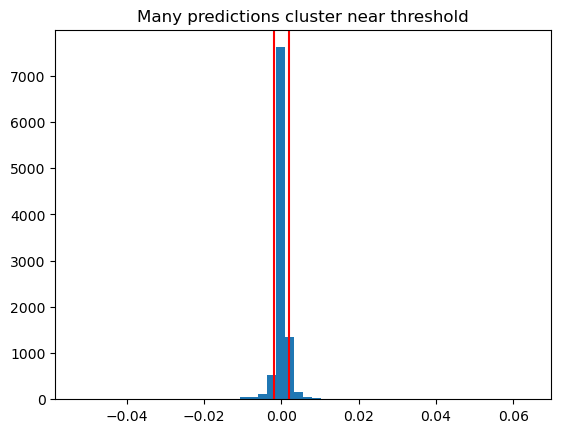

In [688]:
import matplotlib.pyplot as plt

plt.hist(y_pred, bins=50)
plt.axvline(x=0.002, color='r', label='threshold')
plt.axvline(x=-0.002, color='r')
plt.title('Many predictions cluster near threshold')
plt.show()


In [710]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

models = {
  'LightGBM': lgb.LGBMRegressor(
  n_estimators=100,
  learning_rate=0.05,
  max_depth=5,
  min_child_samples=100,
  reg_alpha=0.1,              # L1 regularization
  reg_lambda=0.1,             # L2 regularization
  random_state=42,
  verbose=-1                  # Suppress warnings
  ),
  'RandomForest': RandomForestRegressor(
      n_estimators=100, max_depth=10, min_samples_leaf=100,
      min_samples_split=100, max_features='sqrt', max_samples=0.8,
      random_state=42, n_jobs=-1
  ),
  'XGBoost': XGBRegressor(
      n_estimators=100, max_depth=5, min_child_weight=50,
      reg_alpha=0.1, reg_lambda=0.1, subsample=0.8, colsample_bytree=0.8,
      random_state=42, verbosity=0
  )
}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Model: {name}")
    print('='*50)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    
    table = decile_analysis(y_pred, y_valid)
    print(table)
    
    signals = generate_signal(X_valid, y_pred, threshold=0.0005)
    position = build_position_holdN(signals, N=N)
    position, strategy_returns, equity = evaluate_holdN(df_features, X_valid, signals, N=N)

print("\n\n")
for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Model: {name}")
    print('='*50)
    X_new = np.concatenate([X_train, X_valid], axis=0)
    y_new = np.concatenate([y_train, y_valid], axis=0)
    model.fit(X_new, y_new)
    y_pred = model.predict(X_test)
    
    signals = generate_signal(X_test, y_pred, threshold=0.0005)
    position = build_position_holdN(signals, N=N)
    position, strategy_returns, equity = evaluate_holdN(df_features, X_test, signals, N=N)



Model: LightGBM
        count      mean       std
decile                           
1        1002  0.000187  0.006564
2        1001  0.000231  0.005972
3        1001  0.000085  0.004817
4        1001 -0.000181  0.004744
5        1001 -0.000374  0.004800
6        1001 -0.000071  0.004697
7        1001 -0.000343  0.004714
8        1001  0.000041  0.005732
9        1001  0.000446  0.006879
10       1002  0.000435  0.007696
Long signals:  644
Short signals: 92
Flat:          9276
Metric                   Strategy     Buy-Hold
----------------------------------------------
Sharpe Ratio                 1.51         0.54
Annual Return              31.1%       14.6%
Max Drawdown               -8.3%          N/A
Win Rate (bar)             51.2%          N/A

Model: RandomForest
        count      mean       std
decile                           
1        1002  0.000187  0.007006
2        1001  0.000116  0.005812
3        1001 -0.000052  0.005675
4        1001  0.000056  0.005112
5        1001 -

/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Long signals:  966
Short signals: 144
Flat:          8902
Metric                   Strategy     Buy-Hold
----------------------------------------------
Sharpe Ratio                -0.29         1.82
Annual Return             -13.1%      151.5%
Max Drawdown              -28.6%          N/A
Win Rate (bar)             50.4%          N/A

Model: XGBoost
Long signals:  2553
Short signals: 1565
Flat:          5894
Metric                   Strategy     Buy-Hold
----------------------------------------------
Sharpe Ratio                 2.83         1.82
Annual Return             244.2%      151.5%
Max Drawdown              -17.6%          N/A
Win Rate (bar)             50.3%          N/A


In [59]:
import plotly.graph_objects as go

def plot(df_features):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_features.index, y=df_features["return_1"]))
    return fig

fig = plot(df_features)
fig.show()